In [7]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import timm  # timm (PyTorch Image Models) library for accessing pre-trained models and utilities for image classification
import os  
from tqdm.notebook import tqdm  # tqdm for displaying progress bars in Jupyter notebooks
from torchvision import transforms as T, datasets
from helper import view_classify, show_image, show_grid, accuracy # Importing custom helper functions for visualization and calculating accuracy

In [8]:
# Configuration class to store hyperparameters and dataset information
class CFG:
    
    epochs = 20  # Number of training epochs
    lr = 0.001   # Learning rate for the optimizer
    batch_size = 16  # Batch size for training and validation

    img_size = 224  # Image size for input into the model

    # Paths for dataset directories
    DATA_DIR = "./chest_xray_data"  # Root directory for the dataset
    TEST = 'test'  # Subdirectory for test data
    TRAIN = 'train'  # Subdirectory for training data
    VAL = 'val'  # Subdirectory for validation data

# Setting the device for training/testing. Uses GPU if available, else CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Print statement to confirm the device being used
print("On which device we are on : {}".format(device))


On which device we are on : cuda:1


In [9]:
# Define transformations for the training dataset
train_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size in the CFG class
    T.RandomRotation(degrees=(-20, +20)),  # Apply random rotations between -20 and +20 degrees to augment the data
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using ImageNet's mean and std
])

# Define transformations for the validation dataset
valid_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using the same mean and std
])

# Define transformations for the test dataset
test_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using the same mean and std
])

In [10]:
# Constructing file paths for the training, validation, and test datasets using the CFG class
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)  # Path to the training dataset
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)    # Path to the validation dataset
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)    # Path to the test dataset

print(train_path, valid_path, test_path)

# Loading datasets using ImageFolder, which expects data to be in a certain directory structure
trainset = datasets.ImageFolder(train_path, transform=train_transform)  # Training dataset with transformations
validset = datasets.ImageFolder(valid_path, transform=valid_transform)  # Validation dataset with transformations
testset = datasets.ImageFolder(test_path, transform=test_transform)     # Test dataset with transformations

./chest_xray_data\train ./chest_xray_data\val ./chest_xray_data\test


In [11]:
from torch.utils.data import DataLoader 
testloader = DataLoader(testset, batch_size=CFG.batch_size, shuffle=True)    # DataLoader for the test dataset

In [12]:
import torch.nn as nn
# Creating a pre-trained model from timm (PyTorch Image Models)
model_vgg = timm.create_model('vgg11', pretrained=False)  # Load a pre-trained model specified in CFG
model_vgg.head.fc = nn.Linear(in_features=4096, out_features=2)

model_vgg.load_state_dict(torch.load('VGG11PneumoniaModel.pth'))  # Load the saved state_dict
model_vgg.to(device)  # Move the model to the desired device
model_vgg.eval()  # Set the model to evaluation mode

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [13]:
# Trainer class for handling the training and validation of a neural network model for pneumonia detection
class PneumoniaTrainer():

    # Constructor for initializing the trainer with a loss function, optimizer, and scheduler
    def __init__(self, criterion=None, optimizer=None, schedular=None):
        self.criterion = criterion  # Loss function to use
        self.optimizer = optimizer  # Optimizer for adjusting model weights
        self.schedular = schedular  # Learning rate scheduler (if any)
    
    # Function to perform the training loop over all batches in the training data
    def train_batch_loop(self, model, trainloader):
        train_loss = 0.0  # Variable to accumulate loss over all batches
        train_acc = 0.0   # Variable to accumulate accuracy over all batches

        # Iterate over batches of images and labels in the training dataset
        for images, labels in tqdm(trainloader):
            
            # Move images and labels to the device (GPU or CPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing images to the model
            logits = model(images)
            loss = self.criterion(logits, labels)  # Calculate the batch's loss

            # Backward pass and optimization
            self.optimizer.zero_grad()  # Clear the gradients of all optimized variables
            loss.backward()  # Perform backward pass to calculate gradients
            self.optimizer.step()  # Perform a single optimization step (parameter update)

            # Accumulate loss and accuracy for this batch
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)

        # Calculate average loss and accuracy over all batches
        return train_loss / len(trainloader), train_acc / len(trainloader)
    
    # Function to perform the validation loop over all batches in the validation data
    def valid_batch_loop(self, model, validloader):
        
        valid_loss = 0.0  # Variable to accumulate loss over all batches
        valid_acc = 0.0   # Variable to accumulate accuracy over all batches

        # Iterate over batches of images and labels in the validation dataset
        for images, labels in tqdm(validloader):

            # Move images and labels to the device (GPU or CPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing images to the model
            logits = model(images)
            loss = self.criterion(logits, labels)  # Calculate the batch's loss

            # Accumulate loss and accuracy for this batch
            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)

        # Calculate average loss and accuracy over all batches
        return valid_loss / len(validloader), valid_acc / len(validloader)
    
    # Function to train and validate the model
    def fit(self, model, trainloader, validloader, epochs):
        
        valid_min_loss = np.Inf  # Initialize minimum validation loss to infinity for tracking improvement

        # Training loop for the specified number of epochs
        for i in range(epochs):

            model.train()  # Set the model to training mode
            # Perform training over all batches and get average loss and accuracy
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)

            model.eval()  # Set the model to evaluation mode
            # Perform validation over all batches and get average loss and accuracy
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validloader)

            # Check if validation loss has improved, if so, save the model
            if avg_valid_loss <= valid_min_loss:
                print("Valid_loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), 'VGG11PneumoniaModel.pth')  # Save the model's state_dict
                valid_min_loss = avg_valid_loss  # Update minimum validation loss

            # Print training and validation results for this epoch
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


In [14]:
# Using Cross-Entropy Loss as the criterion for the classification task
criterion = nn.CrossEntropyLoss()

# Setting up the optimizer - Adam optimizer with a learning rate from CFG
optimizer = torch.optim.Adam(model_vgg.parameters(), lr=CFG.lr)

# Instantiating the PneumoniaTrainer class with the defined criterion and optimizer
trainer = PneumoniaTrainer(criterion, optimizer)

In [15]:
# Evaluating the model on the test dataset
avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model_vgg, testloader)

# Printing the test loss and accuracy
print("Test Loss : {}".format(avg_test_loss))  # Print average loss on the test dataset
print("Test Acc : {}".format(avg_test_acc))    # Print average accuracy on the test dataset

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss : 0.8162590157097349
Test Acc : 0.8493589758872986


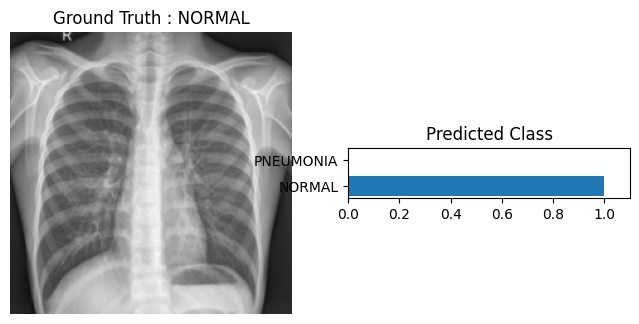

In [20]:
import torch.nn.functional as F 

# Selecting a single image and its label from the test dataset
image, label = testset[4]

# Making a prediction using the model
ps = model_vgg(image.to(device).unsqueeze(0)) 

# Applying softmax to the model's output to convert logits to probabilities
ps = F.softmax(ps, dim=1) 

# Displaying the image, the predicted probabilities, and the actual label
view_classify(image, ps, label) 

In [7]:
del model_vgg  # Delete the model
torch.cuda.empty_cache()  # Clear GPU cache